In [1]:
# Solutions for Exercise 07
# Load all packages you use in the script
import pandas as pd
import numpy as np
import json

import os
import time
import random

from multiprocessing import Pool
from multiprocessing import cpu_count

import operator
import functools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wilcoxon

In [2]:
# For the sake of this exercise, we are interested in whether the Brexit debate on Twitter was more polarized under 
# Theresa May (up to 24 July) than it was under Boris Johnson (from 24 July onwards) as Prime Minister. While this 
# is certainly a simplification that can be problematized, we will operationalize political polarization as the 
# decrease of cosine similarity in pair-wise comparisons of how different users tweet and retweet about Brexit. 
# We thus assume that lower levels of similarity are associated with higher levels of polarization. To answer this 
# question, we need to:

# (1) Split our data into two time-periods (Theresa’s vs. Boris’s incumbency), which we will compare in this exercise.
# Each of the following steps should thus be done separately for these two time-periods.

# Unzipping the files from Absalon>Files>Data>Sample, I put all JSON files until 2019-07-23 in a folder "theresa", 
# and everything thereafter in a folder "boris".
os.listdir("DATA/exercise 7/")

['.DS_Store', 'Theresa', 'Boris', 'processed']

In [3]:
os.listdir("DATA/exercise 7/Theresa")

['2019-04-30_23-19-44.json',
 '2019-06-16_23-41-50.json',
 '2019-06-09_02-08-50.json',
 '2019-04-18_01-32-40.json',
 '2019-05-01_14-51-25.json',
 '2019-04-26_11-21-35.json',
 '2019-04-27_19-46-18.json',
 '2019-07-23_17-09-28.json',
 '2019-03-03_16-41-08.json',
 '2019-06-23_12-59-40.json',
 '2019-04-05_20-39-06.json',
 '2019-03-05_23-03-13.json',
 '2019-05-09_15-29-39.json',
 '2019-05-18_22-06-37.json',
 '2019-03-05_11-00-38.json',
 '2019-05-11_18-10-34.json',
 '2019-06-04_17-48-27.json',
 '2019-05-24_17-25-46.json',
 '2019-07-09_03-00-05.json',
 '2019-05-29_16-01-15.json',
 '2019-07-05_00-20-06.json',
 '2019-04-10_21-51-07.json',
 '2019-05-02_15-22-20.json',
 '2019-05-13_02-51-40.json',
 '2019-03-06_11-58-00.json',
 '2019-06-16_13-25-33.json',
 '2019-03-26_01-10-17.json',
 '2019-03-14_23-38-09.json',
 '2019-04-08_15-41-20.json',
 '2019-03-27_23-19-26.json',
 '2019-03-26_08-58-30.json',
 '2019-03-22_12-22-09.json',
 '2019-05-10_11-25-15.json',
 '2019-05-14_00-28-56.json',
 '2019-04-05_1

In [4]:
print("We got " + str(len(os.listdir("DATA/exercise 7/Theresa"))) + " JSON files for Theresa and " + str(len(os.listdir("DATA/exercise 7/Boris"))) + " JSON files for Boris." )

We got 2110 JSON files for Theresa and 2684 JSON files for Boris.


In [5]:
# (2) Extract information on users’ tweet and retweet texts from the raw Twitter data. This should result in a 
# dataframe with the columns user_handle, tweet_type, tweet_text, re_tweet_text for all status updates in the data.

columns = ["user_handle", "tweet_type", "tweet_text", "re_tweet_text"]

# Define a function that extracts the relevant information from a raw twitter object
def extract_info(tweet):
    # Since some of the twitter objects are broken, let's wrap this all in a try-except
    # statement that skips the processing of a tweet if something goes wrong.
    try:
        tweet = json.loads(tweet)

        # Creating a dictionary instead of a pandas dataframe makes it easier to
        # write short code because we don't have to use .loc or reference the row
        # that we want to change. You can later transform that dictionary with
        # the .DataFrame.from_dict() method from pandas
        new_row = {col: [np.nan] for col in columns}

        new_row['user_handle'] = tweet['user']['screen_name']

        # This distinguishes only between tweets and retweets
        if "retweeted_status" not in tweet:
            new_row['tweet_type'] = "Tweet"

            # Another way to check whether a tweet got cut off is to check whether
            # the truncated value is set to True
            if tweet['truncated']:
                new_row['tweet_text'] = tweet['extended_tweet']['full_text']
            else:
                new_row['tweet_text'] = tweet['text']
        else:
            new_row['tweet_type'] = "Retweet"

            if tweet['retweeted_status']['truncated']:
                new_row['re_tweet_text'] = tweet['retweeted_status']['extended_tweet']['full_text']
            else:
                new_row['re_tweet_text'] = tweet['retweeted_status']['text']        

        new_row = pd.DataFrame.from_dict(new_row)

        return(new_row)
    except:
        pass

In [6]:
# Now that we have a function that can process raw twitter objects, let's 
# loop through all the JSON files and append the overarching dataframes

# Create an empty Pandas dataframe to fill up with the information one-by-one
df_theresa = pd.DataFrame([], columns=columns)

# We can get all the file names with the os package
files_theresa = os.listdir("DATA/exercise 7/Theresa/")

# Note that on MAC, there is always a file ".DS_Store" that gets in the way
# of just getting the JSON files, so let's filter it out
files_theresa = [file for file in files_theresa if file != ".DS_Store"]

# Since this might take a while, let's time it, and run it on a sample of
# 100 JSON files first to see whether we can improve the efficiency of our code.

# You set the seed to make sure you can get the same random sample again
# in case you encounter problems
random.seed(42)

start = time.time()
for file in random.sample(files_theresa, 100):
    # Define the path to each JSON file
    file_path = "DATA/exercise 7/Theresa/" + file
    
    # Now open the JSON file
    json_data = open(file_path).read()
    json_data = json.loads(json_data)
    
    # Now create a second level (or nested loop) that loops
    # thorugh each raw twitter file in this JSON file.
    for tweet in json_data:
        
        # Some twitter objects are broken, so let's make sure
        # this loop does not break if it encounters problems, but
        # rather jumps to the next tweet
        try:
            new_row = extract_info(tweet)
        
            # Append the new row to the master dataframe for theresa
            df_theresa = df_theresa.append(new_row, ignore_index=True)
        except Exception as e:
            print(file_path)
            print(e)
            pass
        
end = time.time()
print("Extracting Tweet information for 100 Theresa JSON files (25.000 tweets) took " + str((end-start)/60) + " minutes.")

Extracting Tweet information for 100 Theresa JSON files (25.000 tweets) took 1.9051419655481974 minutes.


In [7]:
# So, this is running on one CPU core and is taking a lot of time not least
# because each time I append the df_theresa dataframe, it gets loaded into
# memory, and it gets bigger with each iteration of the loop. If you run this
# again and append the dataframe further, the processing time will increase
# gradually.

# The first and easiest solution would be to just let the code run while you 
# cook something nice or go for a walk. Not a problem at all!
# The second solution is to reduce the file sizes by either focusing on a 
# smaller time-period or by sampling the JSON files as mentioned in the 
# exercise description.

# A more efficient solution would be to use list comprehension or multiprocessing
# to first create big lists containing the individual and use the .concat() method
# of the pandas package to put them into a big dataframe at the END of the extraction
# process.

# N.B.: The efficiency of multiprocessing depends a lot on your computer. Whatever
# you see here is based on a machine with 2.9 GHz 6-Core Intel Core i9, amounting
# to 11 useable virtual cores for multiprocessing (12-1). Also my machine has 32GB 
# memory, which might speed up things later on when we do the big batch processing.
# That being said, everything I provide in this script should be optimized so far
# that also a more regular laptop should be able to handle it. It will just take
# a bit longer to process.

# Let's do that for an individual JSON file first for demonstration purposes.
cpu_number = cpu_count() - 1

json_data = open("DATA/exercise 7/Theresa/2019-06-04_17-48-27.json").read()
json_data = json.loads(json_data)

with Pool(cpu_number) as pool:
    list_of_dfs = pool.map(extract_info, [tweet for tweet in json_data])

# So, now we got a list of 250 pandas dataframes each containing one row
# with the information on the individual tweets
list_of_dfs

[  user_handle tweet_type  tweet_text  \
 0  sibradley1    Retweet         NaN   
 
                                        re_tweet_text  
 0  When asked if the NHS should be on the table f...  ,
        user_handle tweet_type  tweet_text  \
 0  NeilHolland1970    Retweet         NaN   
 
                                        re_tweet_text  
 0  This is what Brexit was always going to be abo...  ,
        user_handle tweet_type  tweet_text  \
 0  MikeJos51800765    Retweet         NaN   
 
                                        re_tweet_text  
 0  @GuitarMoog The US model. Eat toxic food. Get ...  ,
       user_handle tweet_type  tweet_text  \
 0  LoikkanenToivo    Retweet         NaN   
 
                                        re_tweet_text  
 0  Like Putin, Trump backs Brexit as it risks the...  ,
   user_handle tweet_type  tweet_text  \
 0   IndeComms    Retweet         NaN   
 
                                        re_tweet_text  
 0  I'm really really happy I don't eat meat

In [8]:
# We can concatenate this list into a pandas dataframe more useful for our purposes
pd.concat(list_of_dfs, ignore_index=True)

,user_handle,tweet_type,tweet_text,re_tweet_text
0,sibradley1,Retweet,NaN,When asked if the NHS should be on the table f...
1,NeilHolland1970,Retweet,NaN,This is what Brexit was always going to be abo...
2,MikeJos51800765,Retweet,NaN,@GuitarMoog The US model. Eat toxic food. Get ...
3,LoikkanenToivo,Retweet,NaN,"Like Putin, Trump backs Brexit as it risks the..."
4,IndeComms,Retweet,NaN,I'm really really happy I don't eat meat any m...
...,...,...,...,...
245,YOUVIEWIT,Tweet,@WhiteHouse @POTUS I thought that Brexit thing...,NaN
246,RobKrygier,Retweet,NaN,If Brexit Party leader @Nigel_Farage thinks th...
247,NotABotTot,Tweet,"@jeremycorbyn @realDonaldTrump Mate, stop poin...",NaN
248,pixiesheena,Retweet,NaN,This is what 3 years of demonising people who ...


In [9]:
# Integrating this new tool into our loop, let's see how much faster it is.
from multiprocessing import Pool
from multiprocessing import cpu_count

Extracting Tweet information for 100 Theresa JSON files (25.000 tweets) took 0.5202068328857422 minutes.


In [10]:
# Another tip to speed up things, which is particularly useful with a lot
# of smaller JSON files like we have here, is to first load all JSON files
# into a big list and only then process the tweets with multiprocessing.
# So we get rid of the slightly inefficient nested-loop structure from above.
# Instead we twice make use of all the processors on our machine.

start = time.time()

# First load all the JSON files
file_paths = ["DATA/exercise 7/Theresa/" + file for file in random.sample(files_theresa, 100)]

with Pool(cpu_number) as pool:
    json_all = pool.map(json.loads, [open(file).read() for file in file_paths])

# With this, we will get a list of lists, which we can flatten with the functools 
# and operator package. There are other ways (e.g., numpy flatten), but this is the
# quickest.
import operator
import functools
json_all = functools.reduce(operator.iconcat, json_all, [])

# Then process each tweet object 
with Pool(cpu_number) as pool:
    list_of_dfs = pool.map(extract_info, [tweet for tweet in json_all])

# Then turn the list of dataframes into one big one
df_theresa = pd.concat(list_of_dfs, ignore_index=True)
    
end = time.time()
print("Extracting Tweet information for 100 Theresa JSON files (25.000 tweets) took " + str((end-start)/60) + " minutes.")

Extracting Tweet information for 100 Theresa JSON files (25.000 tweets) took 0.3945748130480448 minutes.


In [11]:
# Finally, there remains a problem that, once we take the whole 2100 JSON files
# rather than this random sample of 100, the memory of our machine will get clocked
# with stuff that does not necessarily need to be there. The last trick is to
# dump processed tweets in feather files in between to avoid overloading your
# python session. (note that in another context, you might prefer to send each
# individual processed tweet into an SQL server rather than a pandas dataframe,
# which would have the same effect).

# We can use numpy to split the list of files into 20 equally sized chunks
file_paths = ["DATA/exercise 7/Theresa/" + file for file in files_theresa]
chunked = np.array_split(file_paths, 20)

# For each of these chunks of JSON files, we do the same as above.
start_all = time.time()
for x in range(0, len(chunked)):
    start = time.time()
    
    # First load all the JSON files
    file_paths = chunked[x]

    with Pool(cpu_number) as pool:
        json_all = pool.map(json.loads, [open(file).read() for file in file_paths])

    # With this, we will get a list of lists, which we can flatten with the functools 
    # and operator package. There are other ways (e.g., numpy flatten), but this is the
    # quickest.
    import operator
    import functools
    json_all = functools.reduce(operator.iconcat, json_all, [])

    # Then process each tweet object 
    with Pool(cpu_number) as pool:
        list_of_dfs = pool.map(extract_info, [tweet for tweet in json_all])

    # Then turn the list of dataframes into one big one
    df_theresa = pd.concat(list_of_dfs, ignore_index=True)
    
    df_theresa.to_feather("DATA/exercise 7/processed/Theresa/" + str(x) + ".feather")
    end = time.time()
    print("Extracting Tweet information for chunk " + str(x) + " of " + str(len(chunked)) + " took " + str((end-start)/60) + " minutes.")

end_all = time.time()
print("Processing all of Theresa's Tweets took " + str((end_all-start_all)/60) + " minutes.")

Extracting Tweet information for chunk 0 of 20 took 0.984594484170278 minutes.
Extracting Tweet information for chunk 1 of 20 took 0.47370569705963134 minutes.
Extracting Tweet information for chunk 2 of 20 took 0.9390547315279643 minutes.
Extracting Tweet information for chunk 3 of 20 took 0.5175831000010173 minutes.
Extracting Tweet information for chunk 4 of 20 took 0.6494455178578694 minutes.
Extracting Tweet information for chunk 5 of 20 took 0.4728165785471598 minutes.
Extracting Tweet information for chunk 6 of 20 took 0.8536148031552633 minutes.
Extracting Tweet information for chunk 7 of 20 took 0.6015422145525614 minutes.
Extracting Tweet information for chunk 8 of 20 took 0.4529406984647115 minutes.
Extracting Tweet information for chunk 9 of 20 took 0.5093367020289103 minutes.
Extracting Tweet information for chunk 10 of 20 took 0.5599600791931152 minutes.
Extracting Tweet information for chunk 11 of 20 took 0.4916826645533244 minutes.
Extracting Tweet information for chunk

In [12]:
# Now that we have 20 smaller feather files, we can bring them all together into a big one
# for the sake of convenience.
df_theresa = pd.concat([pd.read_feather("DATA/exercise 7/processed/Theresa/" + file) for file in os.listdir("DATA/exercise 7/processed/Theresa/")], ignore_index=True)

# Let's save that so we can easily load the processed tweets into our python session later on 
# when we want to do analytical stuff without repeating the data extraction parts above.
df_theresa.to_feather("DATA/exercise 7/processed/df_theresa.feather")

In [13]:
# And the same for Boris...

# We can use numpy to split the list of files into 20 equally sized chunks
files_boris = os.listdir("DATA/exercise 7/Boris/")
files_boris = [file for file in files_boris if file != ".DS_Store"]

file_paths = ["DATA/exercise 7/Boris/" + file for file in files_boris]
chunked = np.array_split(file_paths, 20)

# For each of these chunks of JSON files, we do the same as above.
start_all = time.time()
for x in range(0, len(chunked)):
    start = time.time()
    
    # First load all the JSON files
    file_paths = chunked[x]

    with Pool(cpu_number) as pool:
        json_all = pool.map(json.loads, [open(file).read() for file in file_paths])

    # With this, we will get a list of lists, which we can flatten with the functools 
    # and operator package. There are other ways (e.g., numpy flatten), but this is the
    # quickest.
    import operator
    import functools
    json_all = functools.reduce(operator.iconcat, json_all, [])

    # Then process each tweet object 
    with Pool(cpu_number) as pool:
        list_of_dfs = pool.map(extract_info, [tweet for tweet in json_all])

    # Then turn the list of dataframes into one big one
    df_boris = pd.concat(list_of_dfs, ignore_index=True)
    
    df_boris.to_feather("DATA/exercise 7/processed/Boris/" + str(x) + ".feather")
    end = time.time()
    print("Extracting Tweet information for chunk " + str(x) + " of " + str(len(chunked)) + " took " + str((end-start)/60) + " minutes.")

end_all = time.time()
print("Processing all of Boris's Tweets took " + str((end_all-start_all)/60) + " minutes.")

df_boris = pd.concat([pd.read_feather("DATA/exercise 7/processed/Boris/" + file) for file in os.listdir("DATA/exercise 7/processed/Boris/")], ignore_index=True)
df_boris.to_feather("DATA/exercise 7/processed/df_boris.feather")

Extracting Tweet information for chunk 0 of 20 took 0.5543283780415853 minutes.
Extracting Tweet information for chunk 1 of 20 took 1.2114595651626587 minutes.
Extracting Tweet information for chunk 2 of 20 took 0.7220741987228394 minutes.
Extracting Tweet information for chunk 3 of 20 took 0.6858442505200704 minutes.
Extracting Tweet information for chunk 4 of 20 took 0.8548451821009319 minutes.
Extracting Tweet information for chunk 5 of 20 took 0.7019892175992329 minutes.
Extracting Tweet information for chunk 6 of 20 took 0.7635789155960083 minutes.
Extracting Tweet information for chunk 7 of 20 took 1.1549453496932984 minutes.
Extracting Tweet information for chunk 8 of 20 took 0.6737888971964519 minutes.
Extracting Tweet information for chunk 9 of 20 took 0.6781582673390706 minutes.
Extracting Tweet information for chunk 10 of 20 took 0.5909369508425395 minutes.
Extracting Tweet information for chunk 11 of 20 took 0.6653882503509522 minutes.
Extracting Tweet information for chunk

In [14]:
# (3) Create joint strings of each user’s tweets and retweets for all users in our data set. For this you will have 
# to find each tweet or retweet originating from a unique user handle in your dataframe.

# After we have accomplished everything in point 2, we can now load our dataframes from local storage:
df_theresa = pd.read_feather("DATA/exercise 7/processed/df_theresa.feather")
df_boris = pd.read_feather("DATA/exercise 7/processed/df_boris.feather")

In [15]:
# As a first step to create joint strings for each user, I would try to find out which users are
# represented in the data. For this, we cann call the .unique() method on the user_handle column
# in our dataset. This returns all unqique values in this column
handles_theresa = df_theresa['user_handle'].unique()
handles_boris = df_boris['user_handle'].unique()

print("Theresa's dataset contains contributions from " + str(len(handles_theresa)) + " unique users.")
print("Boris's dataset contains contributions from " + str(len(handles_boris)) + " unique users.")

Theresa's dataset contains contributions from 203268 unique users.
Boris's dataset contains contributions from 254861 unique users.


In [16]:
# In order to create a joint string with both tweet and retweet texts, let's go through the
# process with a single handle first
test_handle = handles_theresa[0]
test_handle

'JackieBear1872'

In [17]:
# Get the subset of the data related to that user.
user_df = df_theresa.loc[df_theresa['user_handle'] == test_handle, ['tweet_text', "re_tweet_text"]]
user_df

,tweet_text,re_tweet_text
0,None,“The petition to stop Brexit has exposed the l...
17095,None,As Andrew Marr loves trying to bring things up...
49674,@AlbertoOniono @Lordbrexit SIX million pound h...,None
73687,None,@TiceRichard @brexitparty_uk As a life long To...
88662,None,The comments to the man who was bought off are...
116137,🤣😂🤣,None
140874,None,Catch-up: terrific short (15 min) film of the ...
163857,None,POLL: 46% of Tory members would be happy for F...
177953,None,I hope someone somewhere recognises this boy c...
182903,None,Mr Robbins has negotiated another EU/UK Treaty...


In [18]:
# Depending on your operating system, you might get the missing values issue
# again. Since we want to collapse all tweet and retweet texts, it would be
# helpful in this case to replace all missing values with empty strings ("").
# As such, we can use the .join() method without caring too much about them.
user_df = user_df.replace(np.nan, "")


In [19]:
# Now we can collapse them into joint strings. First separately for each
# column, then we can put these two into one.
tweets = " ".join(user_df['tweet_text'])
retweets = " ".join(user_df['re_tweet_text'])

tweets + retweets

'  @AlbertoOniono @Lordbrexit SIX million pound house funded by Soros and co. He\'s an absolute fool and just a common scrounger trying to call himself an activist to dodge working 😂\nhttps://t.co/yAogXnNXtx   🤣😂🤣               “The petition to stop Brexit has exposed the lies of the People’s Vote lobby. For months and months they said they just wanted voters to have a say on the final deal. Now we know that really they want to block Brexit entirely. What a bunch of charlatans.”\n\nBrendan O’Neill on Sky https://t.co/9kDZVPqkqR As Andrew Marr loves trying to bring things up from the past about Nigel Farage that are irrelevant to Brexit  it\'s only fair we do the same.\n\n"I\'m a fool": Married Broadcaster Andrew Marr says sorry for drunken grope of colleague https://t.co/tQpUv1MmIg  @TiceRichard @brexitparty_uk As a life long Tory voter, past Branch Chair, Constituency vice chair and ex councillor, I am frustrated in the Brexit mess,  I now feel unable to support the party any more. If

In [20]:
# If we want to do that for all users, it is worth creating a dataframe upfront that
# we fill with information step by step.
users_theresa = pd.DataFrame({'user_handle': handles_theresa, 
                              'text': np.nan})
users_theresa

,user_handle,text
0,JackieBear1872,NaN
1,PrinceofLutes,NaN
2,radioexe,NaN
3,Dr_Joe97,NaN
4,MonpotLeDevin,NaN
...,...,...
203263,Adelchi16,NaN
203264,theamericanora1,NaN
203265,GlitzyRach,NaN
203266,ShaunBebbers,NaN


In [21]:
# Now we can simply loop through these handles and do what we did above inside a loop,
# but that would again be a fairly slow process that we can immediately speed up with
# some python tricks.
df_theresa = df_theresa.replace(np.nan, "")

# To pass this process into a multiprocessing approach, we need to write it into a function.
# This will inevitably take a while to process because this subsetting is a non-trivial task
# for python. To speed this up, one thing we can do is to turn the handles of the users into
# the index of the df_theresa dataframe. With this, we can immediately select rows by their
# index names rather than writing a boolean query asking where the 'user_handle' column matches
# a specific value.
df_theresa.index = df_theresa['user_handle']

def get_joint_str(handle):
    user_df = df_theresa.loc[handle, ['tweet_text', 're_tweet_text']]
    tweets = " ".join(user_df['tweet_text'])
    retweets = " ".join(user_df['re_tweet_text'])
    return(tweets + retweets)

start = time.time()

with Pool(cpu_number) as pool:
    users_theresa['text'] = pool.map(get_joint_str, [handle for handle in users_theresa['user_handle']])

end = time.time()
print("Creating joint strings for Theresa took " + str((end-start)/60) + " minutes.")

# Again, to avoid having to repeat this process time and again, simply save the result on
# your hard-disk as a feather file.
users_theresa.to_feather("DATA/exercise 7/processed/users_theresa.feather")

Creating joint strings for Theresa took 14.060463921229045 minutes.


In [22]:
# And now the same procedure for Boris...
users_boris = pd.DataFrame({'user_handle': handles_boris, 
                              'text': np.nan})
df_boris = df_boris.replace(np.nan, "")

df_boris.index = df_boris['user_handle']

def get_joint_str(handle):
    user_df = df_boris.loc[handle, ['tweet_text', 're_tweet_text']]
    tweets = " ".join(user_df['tweet_text'])
    retweets = " ".join(user_df['re_tweet_text'])
    return(tweets + retweets)

start = time.time()

with Pool(cpu_number) as pool:
    users_boris['text'] = pool.map(get_joint_str, [handle for handle in users_boris['user_handle']])

end = time.time()
print("Creating joint strings for Boris took " + str((end-start)/60) + " minutes.")

users_boris.to_feather("DATA/exercise 7/processed/users_boris.feather")

Creating joint strings for Boris took 24.56373070081075 minutes.


In [23]:
# (4) Apply a pre-processing logic to these joint strings and vectorize them for the analysis. We want to compare 
# three different approaches to document pre-processing: the political science standard that stops at stemming; 
# spacy’s lemmatizing; and spacy’s document vectors.

# Again, after we finished point 3, we can load the processed files from our hard-disk
users_theresa = pd.read_feather("DATA/exercise 7/processed/users_theresa.feather")
users_boris = pd.read_feather("DATA/exercise 7/processed/users_boris.feather")

In [24]:
# Let's start with the standard pre-processing, which we can copy-paste from previous scripts from
# this class.

# Load all dependencies 
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

import string
punct = string.punctuation
punct = punct + "’"

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Rather than writing a for-loop, however, we define a
# function.
def pre_process(tweet):
    # Turn string into list of tokens
    tokens = tokenizer.tokenize(tweet)
    
    # Lowercase every token
    tokens = [t.lower() for t in tokens]
    
    # Remove punctuation from token list
    tokens = [t for t in tokens if t not in punct]
    
    # Remove stopwords from token list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    
    # URL removal
    tokens = [t for t in tokens if not "https://" in t]
    
    # Whitespace separate all tokens into one string
    tweet = " ".join(tokens)
    
    # And return the pre-processed tweet
    return(tweet)

In [25]:
# We can also pass several lines at the same time to the multiprocessing approach
start = time.time()

with Pool(cpu_number) as pool:
    users_theresa['pre_processed'] = pool.map(pre_process, [text for text in users_theresa['text']])
    users_boris['pre_processed'] = pool.map(pre_process, [text for text in users_boris['text']])
    
end = time.time()
print("Pre-processing for Theresa and Boris took " + str((end-start)/60) + " minutes.")

Pre-processing for Theresa and Boris took 2.2483104705810546 minutes.


In [26]:
# With spacy, one of the ways to speed up pre-processing is to disable functionalities
# that we don't need for the purpose of this. Named Entitity recognition, for example
# is not really necessary for extracting lemmas
import spacy
nlp = spacy.load("en_default", disable=["ner"])

def lemmatize(text):
    doc = nlp(text)
    
    text = [token.lemma_ for token in doc]
    text = " ".join(text)
    
    return(text)

# Get lemmas
start = time.time()

with Pool(cpu_number) as pool:
    users_theresa['lemmas'] = pool.map(lemmatize, [text for text in users_theresa['text']])
    users_boris['lemmas'] = pool.map(lemmatize, [text for text in users_boris['text']])
    
end = time.time()
print("Lemmatizing for Theresa and Boris took " + str((end-start)/60) + " minutes.")

Lemmatizing for Theresa and Boris took 22.134763995806377 minutes.


In [27]:
# For the word vectors, we can further disable a bunch of other things in the spacy model
nlp = spacy.load("en_default", disable=["tagger", "parser", "ner"])

def doc_vectorize(text):
    doc = nlp(text)
    vector = doc.vector
    return(vector)

# Get word vectors
start = time.time()

with Pool(cpu_number) as pool:
    theresa_vecs = pool.map(doc_vectorize, [text for text in users_theresa['text']])
    boris_vecs = pool.map(doc_vectorize, [text for text in users_boris['text']])
    
end = time.time()
print("Word vector retrieval for Theresa and Boris took " + str((end-start)/60) + " minutes.")

Word vector retrieval for Theresa and Boris took 1.4127915183703104 minutes.


In [28]:
# We can now save the save the pandas dataframes with the pre_processed and lemmas
# variable on our computer to prevent having to repeat this again.
users_theresa.to_feather("DATA/exercise 7/processed/users_theresa.feather")
users_boris.to_feather("DATA/exercise 7/processed/users_boris.feather")

In [29]:
# If we turn the list of doc vectors into a numpy array, we can simply use np.save
# to do so for the doc vectors as well.
vecs_theresa = np.array(theresa_vecs)
vecs_boris = np.array(boris_vecs)

np.save("DATA/exercise 7/processed/vecs_theresa.npy", vecs_theresa)
np.save("DATA/exercise 7/processed/vecs_boris.npy", vecs_boris)

In [30]:
# In case we want to pick up at this stage of our script, we can now load the processed
# data into our python session with the following few lines

users_theresa = pd.read_feather("DATA/exercise 7/processed/users_theresa.feather")
users_boris = pd.read_feather("DATA/exercise 7/processed/users_boris.feather")

vecs_theresa = np.load("DATA/exercise 7/processed/vecs_theresa.npy")
vecs_boris = np.load("DATA/exercise 7/processed/vecs_boris.npy")

In [31]:
# The final step would be to vectorize the pre_processed and lemmas texts for further 
# Note that document vectors are already in a format that can be put into functions
# like cosine similarity, so no further steps necessary there...

def split_tok(text):
    return(text.split())

vec = CountVectorizer(tokenizer=split_tok)

dtm_pp_theresa = vec.fit_transform(users_theresa['pre_processed'])
dtm_pp_boris = vec.fit_transform(users_boris['pre_processed'])

dtm_lem_theresa = vec.fit_transform(users_theresa['lemmas'])
dtm_lem_boris = vec.fit_transform(users_boris['lemmas'])

In [32]:
# (5) Calculate pairwise cosine similarities for each combination of two users in our data.

# Let's do cosine similarity for pre_processed first. Note that these pair-wise comparisons
# quickly grow out of hand the more users you have. If we have 200.000 users in our Theresa
# dataset, this would mean that python has to calculate 200.000*200.000 cosine similarity
# values, which amounts to forty billion datapoints. Luckily, random samples of our user
# dataframe will get us close enough to the real values that we can use this to render this
# task manageable for our computers. If we take a random sample of 1000 users, we end up with
# 1.000.000 datapoints, which is manageable given that it is just simple numerical objects.

# So let's just get a 1000 randomely sampled index values from the users dataframes, which
# will match onto our dtms and word vector objects. For robustness checks, we could repeat
# this step with different seeds to see if the substantive conclusions change. If yes, we 
# might want to increase the size of the sample.
random.seed(42)
sample_theresa = random.sample(range(0, len(users_theresa)), 1000)
sample_boris = random.sample(range(0, len(users_boris)), 1000)

In [33]:
# With this, calculating cosine similarity should be done in no time.
csim_pp_theresa = cosine_similarity(dtm_pp_theresa[sample_theresa,])
csim_pp_boris = cosine_similarity(dtm_pp_boris[sample_boris,])

csim_lem_theresa = cosine_similarity(dtm_lem_theresa[sample_theresa,])
csim_lem_boris = cosine_similarity(dtm_lem_boris[sample_boris,])

csim_vec_theresa = cosine_similarity(vecs_theresa[sample_theresa,])
csim_vec_boris = cosine_similarity(vecs_boris[sample_boris,])

In [34]:
# (6) Compare the distributions of cosine similarities in the two time-periods to check whether there was a discursive
# change associated with the change in leadership. You can use boxplots, density plots, and/or Wilcoxon tests.

# In order to simply compare the distributions of all pairwise cosine similarity scores, we can flatten the
# two-dimensional arrays from above into a simple array containing all individual numbers with the .flatten()
# method from numpy.
csim_pp_theresa = csim_pp_theresa.flatten()
csim_pp_boris = csim_pp_boris.flatten()

csim_lem_theresa = csim_lem_theresa.flatten()
csim_lem_boris = csim_lem_boris.flatten()

csim_vec_theresa = csim_vec_theresa.flatten()
csim_vec_boris = csim_vec_boris.flatten()

In [35]:
# Doing some simple statistics, we can use the non-parametric wilcoxon test to
# see whether our two distributions are systematically different or not. It's 
# similar to the t-test you might know better, but without assumptions about
# the nature of our two distributions
from scipy.stats import wilcoxon

# This function returns two values, the second of which is the two-way p-value,
# which we can use for significance testing.
print("Pre-processed p-value is: " + str(wilcoxon(csim_pp_theresa, csim_pp_boris)[1]))
print("Lemmas p-value is: " + str(wilcoxon(csim_lem_theresa, csim_lem_boris)[1]))
print("Doc Vectors p-value is: " + str(wilcoxon(csim_vec_theresa, csim_vec_boris)[1]))

Pre-processed p-value is: 5.123338977634612e-10
Lemmas p-value is: 1.6578284525091966e-15
Doc Vectors p-value is: 1.4315976169658217e-06


In [36]:
# As you can see, all of these p-values are super low, meaning that from a statistical
# point of view, the discourse on Twitter has changed with the change in Prime Minister.
# Of course, there is no way we could attribute this to a causal relationship between
# discourse and who is in office. It's simply a descriptive insight. However, statistical 
# significance analysis tends to be a bit boring, so let's try to get a more visual impression
# of these distributions.

# For visualization, it is useful to turn these arrays into dataframes with the appropriate labels
# for the plots. Since we sampled this data, we can be sure that each of these has the same dimensions
# which makes it easier to put them all together into one nice dataframe
plot_theresa = pd.DataFrame({"time_frame": "Theresa",
                            "Pre-Processed": csim_pp_theresa,
                            "Lemmas": csim_lem_theresa,
                            "Vectors": csim_vec_theresa})
plot_boris = pd.DataFrame({"time_frame": "Boris",
                            "Pre-Processed": csim_pp_boris,
                            "Lemmas": csim_lem_boris,
                            "Vectors": csim_vec_boris})
df_plot = plot_theresa.append(plot_boris)
df_plot

,time_frame,Pre-Processed,Lemmas,Vectors
0,Theresa,1.000000,1.000000,1.000000
1,Theresa,0.000000,0.042256,0.445897
2,Theresa,0.000000,0.055999,0.452928
3,Theresa,0.906968,0.783751,0.960498
4,Theresa,0.000000,0.013367,0.438129
...,...,...,...,...
999995,Boris,0.942764,0.945226,0.996688
999996,Boris,0.962082,0.895905,0.989062
999997,Boris,0.933658,0.912488,0.991521
999998,Boris,0.914727,0.918691,0.992147


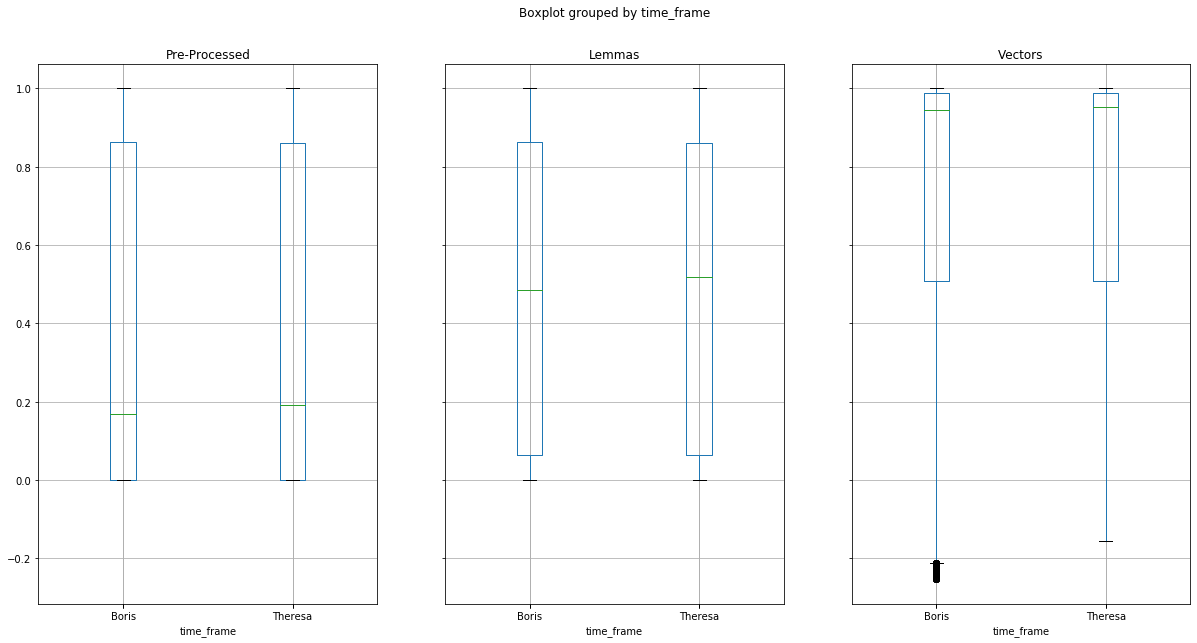

In [38]:
# A shortcut for making boxplots in python, which I unfortunately just discovered now
# (long live ggplot!), is to just call the .boxplot() method on a pandas dataframe.
# Meaning that pandas already has some basic plotting functionalities integrated, which
# nevertheless build upon matplotlib.
boxplot = df_plot.boxplot(column=["Pre-Processed", "Lemmas", "Vectors"], 
                          by="time_frame",
                          layout=(1, 3),
                          figsize=(20.0, 10.0))

# If we fall back on our initial assumption that lower levels of cosine similarity indicate higher
# levels of political polaritzation, there seems to be a light shift toward more polarization during
# Boris's incumbency in our data. You can see that the mean similarity in the pre-processed and lemmatized
# versions are slightly higher for Theresa. While this difference in mean is less visible for the Vectors,
# we can see a tail towards negative cosine similarities that is more pronounced for Boris than for Theresa.

# As mentioned, this is just an exercise and using cosine similarity to operationalize polarization can
# be challenged. If we accept that word vectors capture semantic information, we might put more meaning
# into such an interpretation of the similarity distributions for the vectors, but this remains debatable.
# Mostly, the point of this exercise was to practice your python skills in handling larger amounts of data.